In [1]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import cv2 

In [2]:
# --- 1. Load the Pre-trained VGG16 Model ---

# Load the VGG16 model with weights pre-trained on the ImageNet dataset.
# VGG16 is a deep convolutional neural network that is a powerful feature extractor.
print("Loading VGG16 model pre-trained on ImageNet...")
model = VGG16(weights='imagenet')

# Display a summary of the model's architecture
print("\nModel Summary:")
model.summary()

Loading VGG16 model pre-trained on ImageNet...

Model Summary:


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# --- 2. Load and Preprocess the Image ---

# Load the image from the file path. VGG16 expects input images of size 224x224 pixels.
img = load_img('phone.jpg', target_size=(224, 224))

# Convert the loaded image into a NumPy array.
# The shape will be (224, 224, 3) for Height, Width, Channels (RGB).
img_array = img_to_array(img)

# Add an extra dimension to the array to create a "batch" of one image.
# The model expects input shape of (batch_size, height, width, channels).
# So, we change the shape from (224, 224, 3) to (1, 224, 224, 3).
img_batch = np.expand_dims(img_array, axis=0)

# Preprocess the image for the VGG16 model.
# This function handles the necessary scaling and channel ordering that VGG16 was trained on.
preprocessed_image = preprocess_input(img_batch)

print(f"Image preprocessed successfully. Shape: {preprocessed_image.shape}")

Image preprocessed successfully. Shape: (1, 224, 224, 3)


In [6]:
# --- 3. Make a Prediction ---

print("\nMaking a prediction...")
# Use the model's .predict() method to get the classification probabilities.
# The output will be a vector of 1000 probabilities, one for each ImageNet class.
predictions = model.predict(preprocessed_image)


Making a prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step



Top 5 Predictions:
1: iPod (91.43%)
2: cellular_telephone (3.83%)
3: remote_control (1.24%)
4: hand-held_computer (0.69%)
5: packet (0.27%)


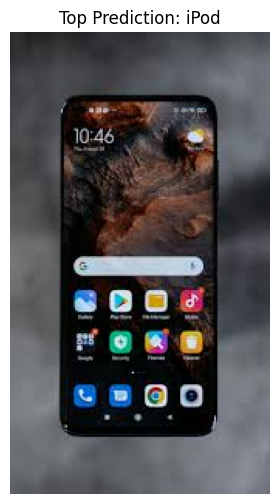

In [8]:
# --- 4. Decode and Display the Results ---

# The decode_predictions function converts the raw probabilities into human-readable labels.
# It returns a list of the top 5 most likely predictions.
decoded_predictions = decode_predictions(predictions, top=5)[0]

print("\nTop 5 Predictions:")
for i, (imagenet_id, label, score) in enumerate(decoded_predictions):
    print(f"{i+1}: {label} ({score:.2%})")

# Display the original image using Matplotlib and OpenCV for correct color display
# OpenCV loads images in BGR, so we convert it to RGB for Matplotlib.
display_image = cv2.imread('phone.jpg')
display_image = cv2.cvtColor(display_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 6))
plt.imshow(display_image)
plt.title(f"Top Prediction: {decoded_predictions[0][1]}")
plt.axis('off')
plt.show()